In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re

In [2]:
# metric in long-term-forecasting
# mae, mse, rmse, mape, mspe

In [3]:
path = './results_long_term_forecasting'
model = 'non_transformer'
datasets = os.listdir(os.path.join(path, f'resultsGym_{model}'))
result_dict, runtime_dict = {}, {}
for dataset in datasets:
    result_dict[dataset], runtime_dict[dataset] = {}, {}
    pred_lens = [96, 192, 336, 720] if dataset not in ['ili', 'fred-md', 'covid-19'] else [24, 36, 48, 60]
    for pred_len in pred_lens:
        file_list = os.listdir(os.path.join(path, f'resultsGym_{model}', dataset))
        file_list = [_ for _ in file_list if f'pl{pred_len}' in _]
        result_dict[dataset][pred_len], runtime_dict[dataset][pred_len] = {}, {}
        for file in file_list:
            try:
                result = np.load(os.path.join(path, f'resultsGym_{model}', dataset, file, 'metrics.npy'), allow_pickle=True)
                result_dict[dataset][pred_len][file] = result[1]
                
                # runtime = np.load(os.path.join(path_runtime, 'custom_Monthly_'+model[model.find('TSGym'): model.find('custom')-1]+'_fit_time_per_epoch.npz'), allow_pickle=True)
                # runtime_dict[pred_len][model] = runtime['time']
            except:
                pass
                continue

        metrics = result_dict[dataset][pred_len].values()
        metrics = np.array(list(metrics))
        # metrics = np.argsort(np.argsort(metrics))
        # metrics = (metrics + 1) / len(metrics)

        result_dict[dataset][pred_len] = {k: metrics[i] for i, k in enumerate(result_dict[dataset][pred_len].keys())}

In [4]:
# df = pd.DataFrame.from_dict(result_dict[96], orient='index') if dataset not in ['ili', 'fred-md', 'covid-19'] else pd.DataFrame.from_dict(result_dict[24], orient='index')
# print(df.shape)
# df.columns = ['mse']

# # df_runtime = pd.DataFrame.from_dict(runtime_dict[96], orient='index')
# # df_runtime.columns = ['runtime-per-epoch']

# # df = pd.concat([df, df_runtime], axis=1).dropna()

# # df = df.loc[[_ for _ in df.index if 'LLM' in _ or 'TSFM' in _]]
# df.sort_values(by='mse').head(20)
# # df.sort_values(by='runtime-per-epoch', ascending=True).head(20)

In [5]:
# df = pd.DataFrame.from_dict(result_dict[192], orient='index')
# df.columns = ['mse']
# df.sort_values(by='mse').head(20)
# # df.sort_values(by='mse').to_csv('gym_192.csv', index=True)

In [6]:
# df = pd.DataFrame.from_dict(result_dict[336], orient='index')
# df.columns = ['mse']
# df.sort_values(by='mse').head(20)
# # df.sort_values(by='mse').to_csv('gym_336.csv', index=True)

In [7]:
# df = pd.DataFrame.from_dict(result_dict[720], orient='index')
# df.columns = ['mse']
# df.sort_values(by='mse').head(20)
# # df.sort_values(by='mse').to_csv('gym_720.csv', index=True)

In [8]:
# result_dict_vis = result_dict.copy()
# for pred_len in pred_lens:
#     result_dict_vis[pred_len] = {k[k.find('TSGym')+6: k.find('custom')-1]:v for k, v in result_dict_vis[pred_len].items()}

result_dict_vis = {}
for pred_len_1, pred_len_2 in zip([96, 192, 336, 720], [24, 36, 48, 60]):
    metrics = pd.concat([pd.Series(result_dict[dataset][96]) if dataset not in ['ili', 'fred-md', 'covid-19'] 
                    else pd.Series(result_dict[dataset][24]) for dataset in datasets], axis=1)
    metrics = metrics.mean(axis=1)
    result_dict_vis[pred_len_1] = metrics.to_dict()

for pred_len in pred_lens:
    result_dict_vis[pred_len] = {'_'.join([k[k.find('TSGym')+6: k.find('custom')-1],
                                           re.search(r'sl(\d+)', k)[0],
                                           re.search(r'dm(\d+)', k)[0],
                                           re.search(r'df(\d+)', k)[0],
                                           re.search(r'el(\d+)', k)[0],
                                           re.search(r'epochs(\d+)', k)[0],
                                           re.search(r'lf([A-Za-z]+)', k)[0],
                                           re.search(r'lr(\d+(?:\.\d+)?)', k)[0],
                                           re.search(r'lrs([A-Za-z]+)', k)[0]]):v for k, v in result_dict_vis[pred_len].items()}

In [9]:
# # todo: NaN values?
# intros = ['x_mark', 'multi-granularity', 'Normalization', 'Decomposition', 'Channel-independent',
#           'Tokenization', 'Backbone', 'Attention', 'Feature-Attention', 'Encoder-only', 'Frozen', 'Dataset', 'ftM',
#           'Sequence Length', 'll', 'pl', 'd_model', 'Encoder layers', 'Decoder layers', 'd_ff',
#           'factor', 'embed', 'distil', 'des',
#           'Training Epochs', 'Loss Function', 'Learning Rate', 'Learning Rate Strategy']
# n = 0
# while True:
#     fig = plt.figure(figsize=(16, 2.5)); intro = intros[n]
#     for i, pred_len in enumerate(pred_lens):
#         result_dict_vis_comp = {}
#         fig.add_subplot(1, 4, i+1)
#         comps = set([_.split('_')[n] for _ in result_dict_vis[pred_len].keys()])
#         if len(comps) <= 1: continue
#         for j, comp in enumerate(comps):
#             result_dict_vis_comp[comp] = {k:v for k, v in result_dict_vis[pred_len].items() if k.split('_')[n] == comp}
#             v = np.array(list(result_dict_vis_comp[comp].values()))
#             v = v[~np.isnan(v)]
#             v = v[v < 1e+4] # todo: 为什么有mse溢出的情况?

#             plt.boxplot(v, positions=[j], showfliers=False)
#             plt.text(j, np.quantile(v, 0.75), str(len(v)), ha='center', va='bottom')
#             # plt.ylim(0.0, 3.0)

#         plt.xticks(range(len(result_dict_vis_comp)), result_dict_vis_comp.keys(), rotation=-90)
#         plt.title(f'pred_len: {pred_len}')
        
    
#     if len(comps) > 1:
#         print(comps)
#         fig.suptitle(intro)
#         plt.show()
#     else:
#         plt.close()
#     n += 1
#     if n >= len(intros): break

{'False', 'True'}


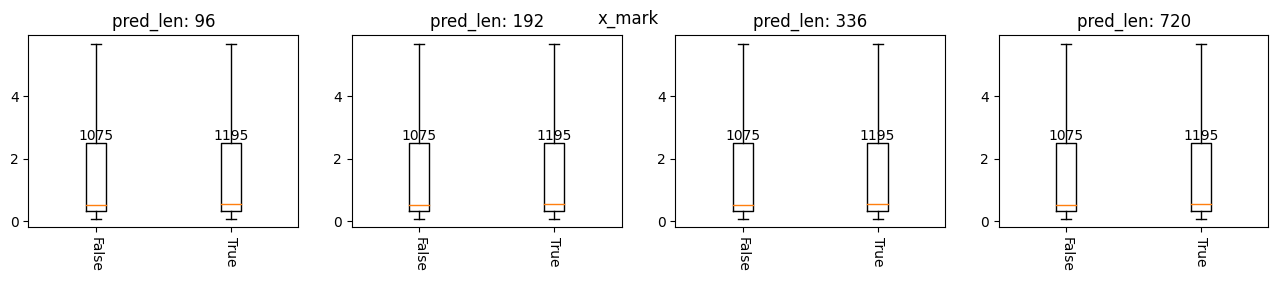

{'False', 'True'}


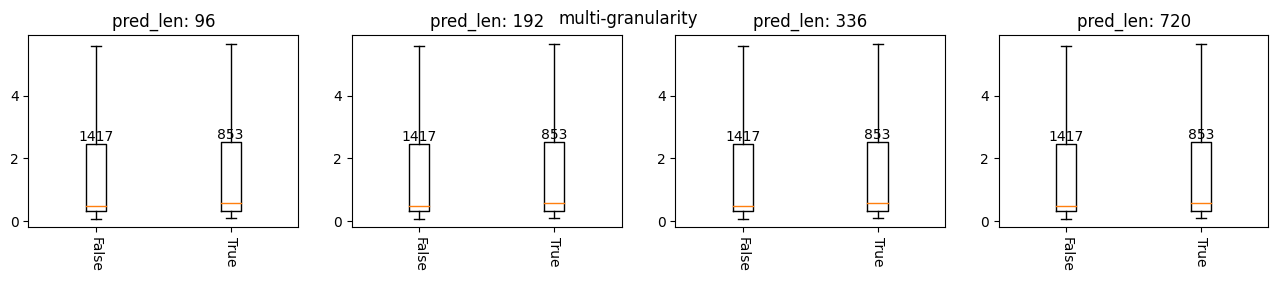

{'DishTS', 'RevIN', 'None', 'Stat'}


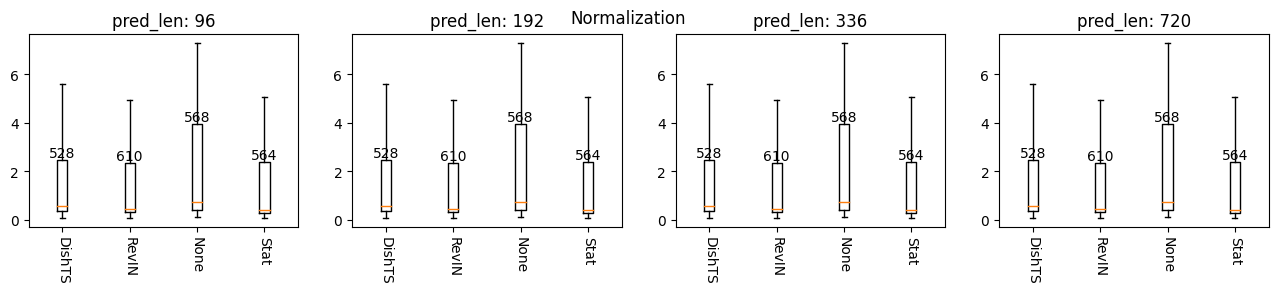

{'MoEMA', 'None', 'MA', 'DFT'}


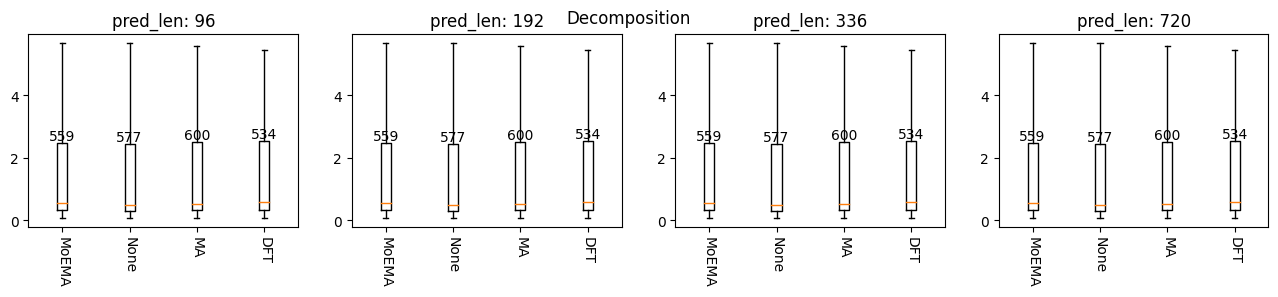

{'False', 'True'}


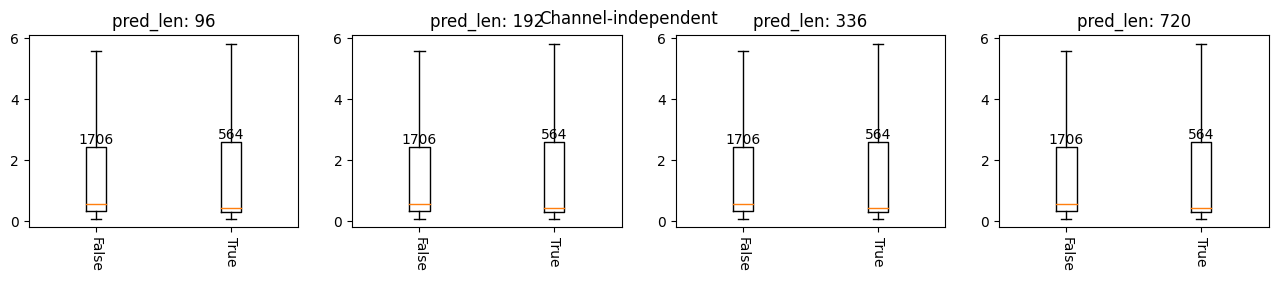

{'inverted-encoding', 'series-encoding', 'series-patching'}


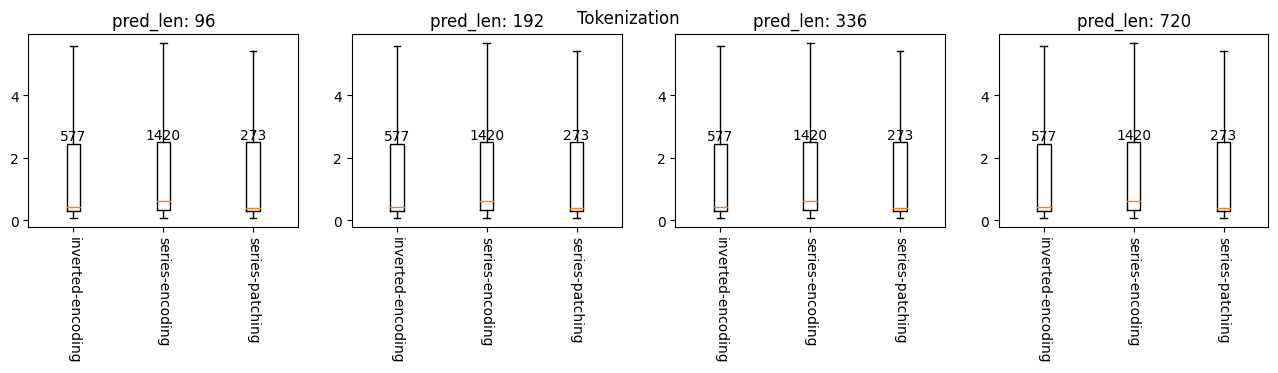

{'GRU', 'MLP'}


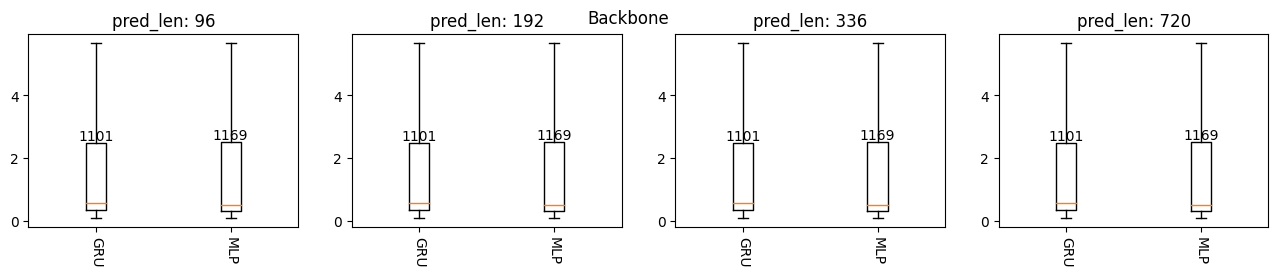

{'null', 'sparse-attention', 'frequency-enhanced-attention', 'self-attention'}


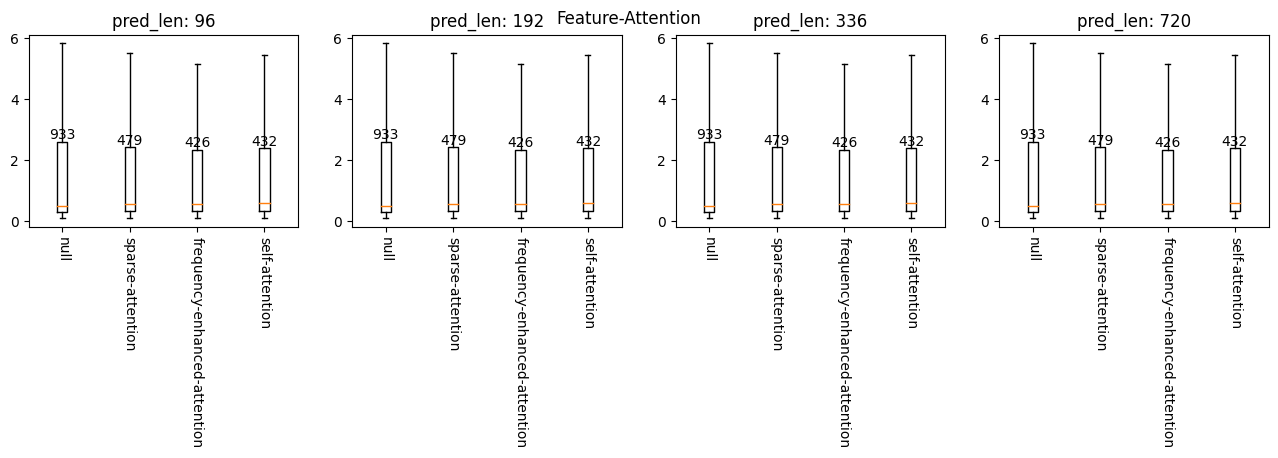

{'sl48', 'ETTm2', 'sl96', 'sl192', 'ETTm1', 'sl512', 'ETTh1', 'ETTh2'}


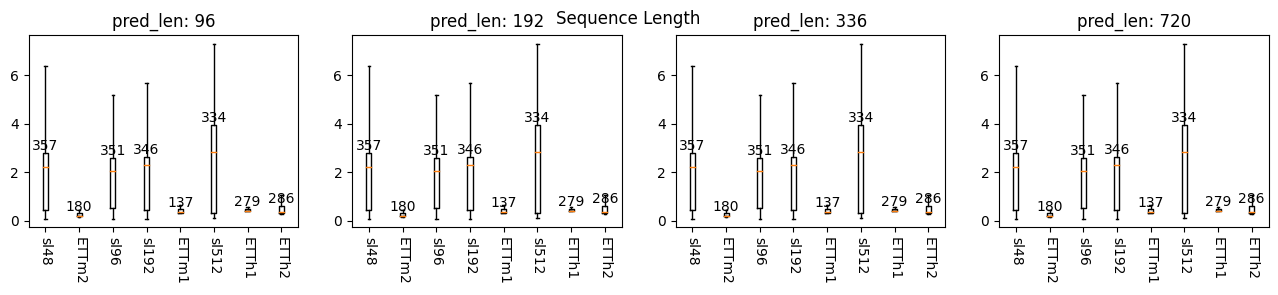

{'dm256', 'dm64', 'ftM'}


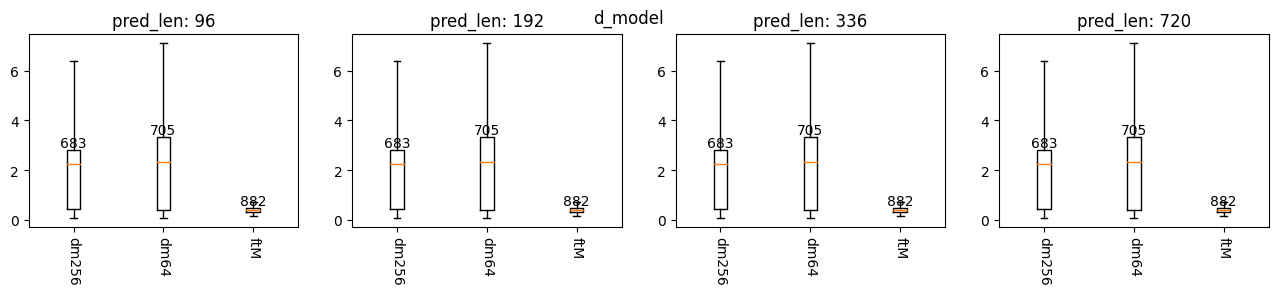

{'sl48', 'sl96', 'sl192', 'df256', 'sl512', 'df1024'}


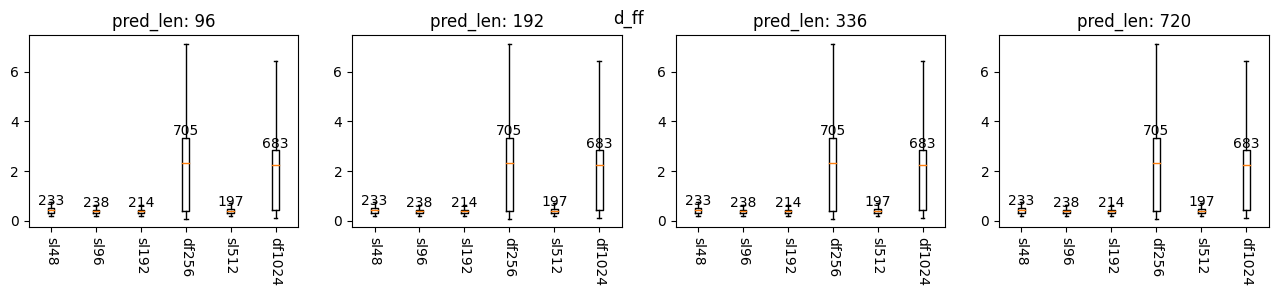

{'el2', 'el3', 'll48'}


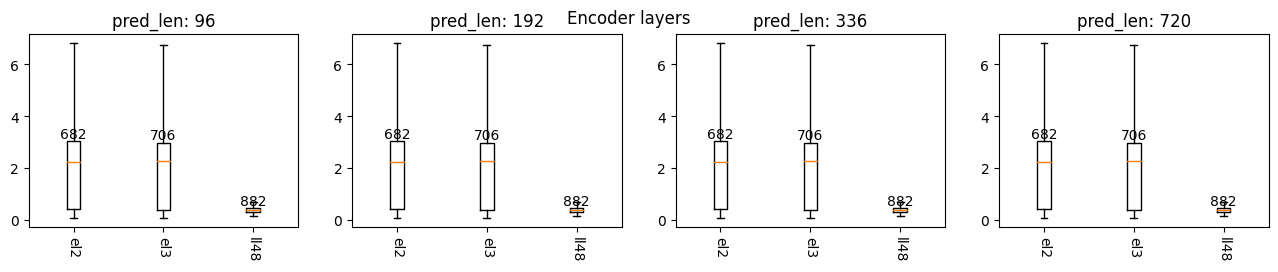

{'epochs10', 'epochs50', 'pl96', 'epochs20'}


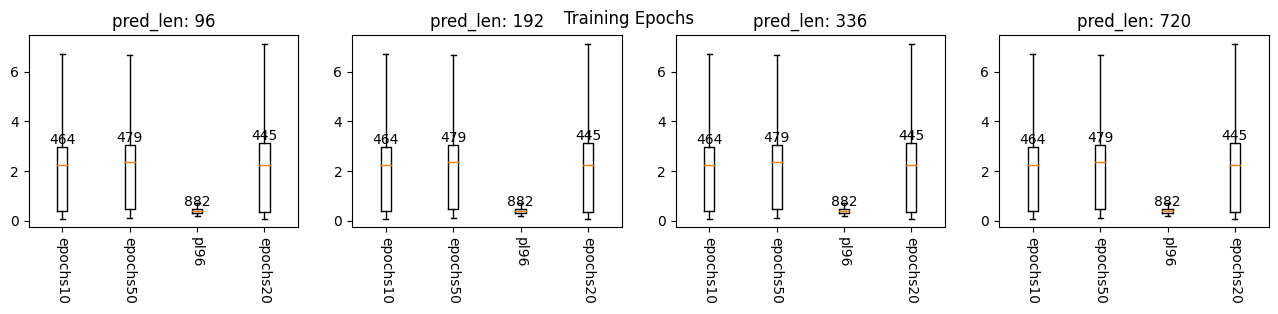

{'lfMSE', 'dm64', 'dm256'}


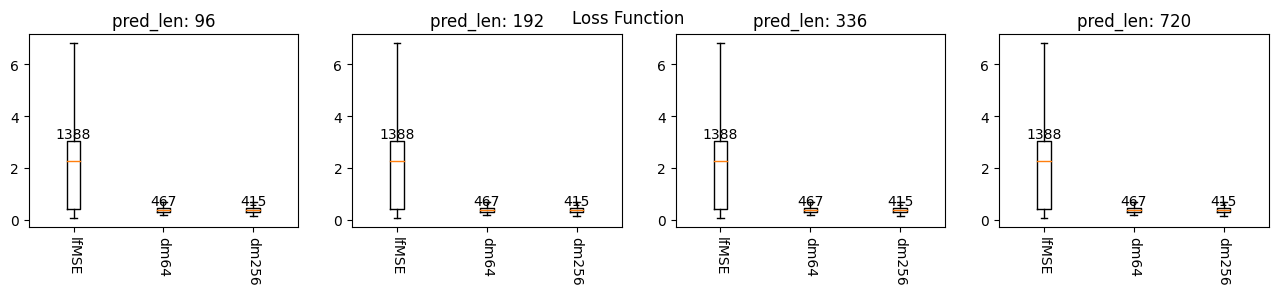

{'lr0.001', 'el2', 'el3', 'lr0.0001'}


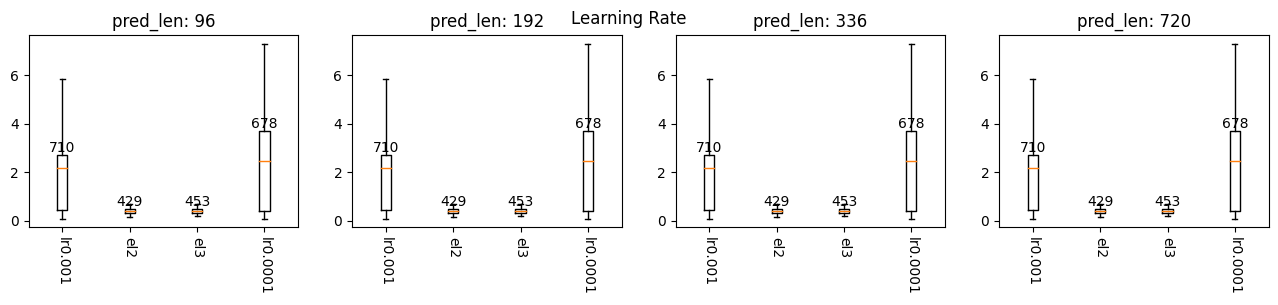

{'dl1', 'lrstype', 'lrsnull'}


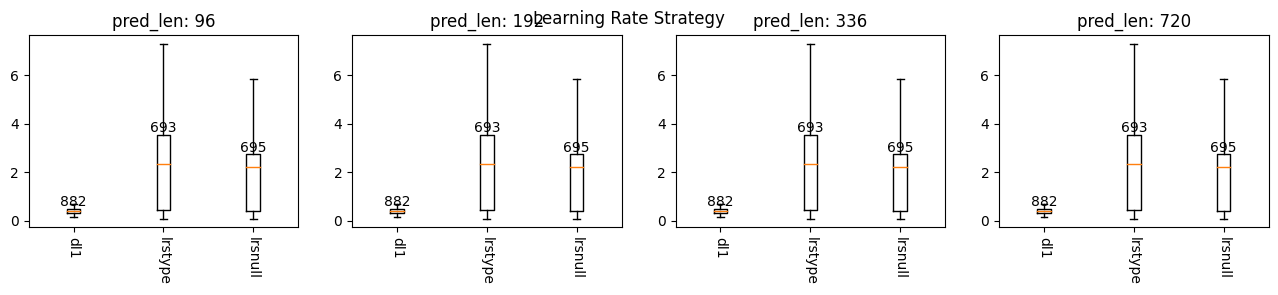

In [10]:
# todo: NaN values?
intros = ['x_mark', 'multi-granularity', 'Normalization', 'Decomposition', 'Channel-independent',
          'Tokenization', 'Backbone', 'Attention', 'Feature-Attention', 'Encoder-only', 'Frozen',
          'Sequence Length', 'd_model', 'd_ff', 'Encoder layers',
          'Training Epochs', 'Loss Function', 'Learning Rate', 'Learning Rate Strategy']
n = 0
while True:
    fig = plt.figure(figsize=(16, 2.5)); intro = intros[n]
    for i, pred_len in enumerate(pred_lens):
        result_dict_vis_comp = {}
        fig.add_subplot(1, 4, i+1)
        comps = set([_.split('_')[n] for _ in result_dict_vis[pred_len].keys()])
        if len(comps) <= 1: continue
        for j, comp in enumerate(comps):
            result_dict_vis_comp[comp] = {k:v for k, v in result_dict_vis[pred_len].items() if k.split('_')[n] == comp}
            v = np.array(list(result_dict_vis_comp[comp].values()))
            v = v[~np.isnan(v)]
            v = v[v < 1e+4] # todo: 为什么有mse溢出的情况?

            plt.boxplot(v, positions=[j], showfliers=False)
            plt.text(j, np.quantile(v, 0.75), str(len(v)), ha='center', va='bottom')
            # plt.ylim(0.0, 3.0)

        plt.xticks(range(len(result_dict_vis_comp)), result_dict_vis_comp.keys(), rotation=-90)
        plt.title(f'pred_len: {pred_len}')
        
    
    if len(comps) > 1:
        print(comps)
        fig.suptitle(intro)
        plt.show()
    else:
        plt.close()
    n += 1
    if n >= len(intros): break

In [13]:
k = list(result_dict_vis[pred_len].keys())[0]
